 # Fruit Ripeness Detection 

### Importing required libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import glob
import cv2
import seaborn as sns
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
TRAIN_PATH = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/train'
VAL_PATH = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/val'
TEST_PATH = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/test'

### Initializing Image Size

In [3]:
IMAGE_SIZE = (224, 224)

### Initializing train, validation & test data

In [4]:
training_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=IMAGE_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=IMAGE_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    validation_split=None,
    subset=None,
    shuffle=False,
    batch_size=32,
    image_size=IMAGE_SIZE
)


Found 5280 files belonging to 3 classes.
Found 1320 files belonging to 3 classes.
Found 660 files belonging to 3 classes.


2024-02-19 09:43:06.232775: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-19 09:43:06.232813: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-19 09:43:06.232816: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-19 09:43:06.232867: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-19 09:43:06.233100: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Plot Images with labels

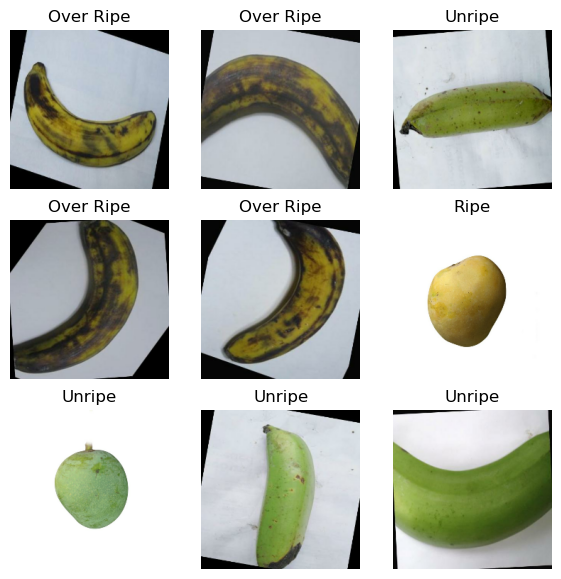

In [5]:
plt.figure(figsize=(7, 7))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(training_ds.class_names[labels[i]])
        plt.axis("off")

In [6]:
class_num = 3
input_shape = (224,224,3)

### Import model for Transfer Learning

In [7]:
efficientnet = tf.keras.applications.efficientnet.EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling="avg",
    classes=class_num
)

In [8]:
efficientnet.summary() 

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0

### Freeze layerns in EfficientNetB1

In [9]:
for layer in efficientnet.layers[:-5]:
    layer.trainable = False

In [10]:
for layer in efficientnet.layers:
    print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block1c_dwconv False
block1c_bn False
block1c_activation False
block1c_se_squeeze False
block1c_se_reshape False
block1c_se_reduce False
block1c_se_expand False
block1c_se_excite False
block1c_project_conv False
block1c_project_bn False
block1c_drop False
block1c_add False
block1d_dwconv False
block1d_bn False
block1d_activation False
block1d_se_s

### Building the classification model

In [11]:
inputs = tf.keras.Input(shape=input_shape, name='image_input')

x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = efficientnet(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(.3)(x)
outputs = Dense(class_num, activation='softmax')(x)

effnet_model = tf.keras.Model(inputs, outputs, name='output')

### Compile the model

In [12]:
def learning_rate_schedule(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(learning_rate_schedule)

In [13]:
effnet_model.compile(
    optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

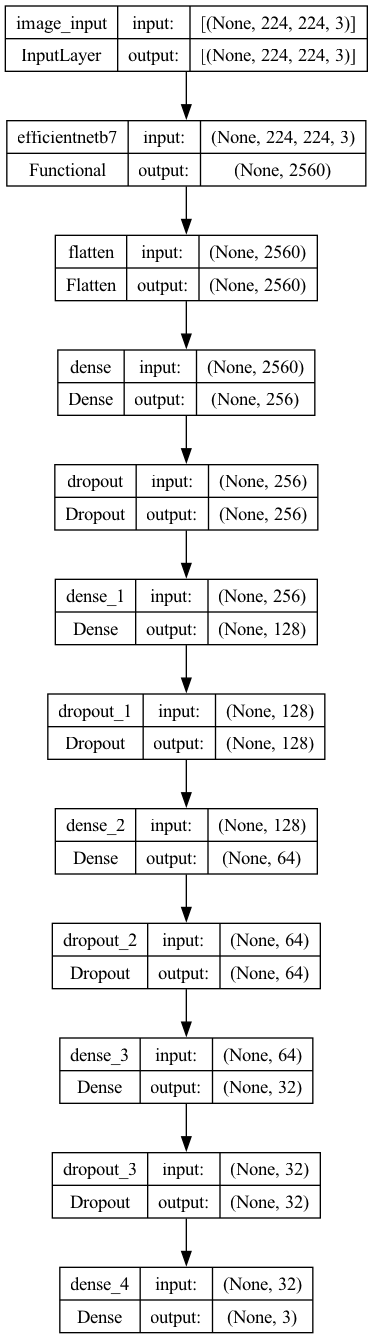

In [14]:
from tensorflow.keras.utils import plot_model

plot_model(effnet_model, to_file='model_eff.png',show_shapes=True, show_layer_names=True)

### Train the model

In [15]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)
mc =  ModelCheckpoint('best_model_ripeness.h5', monitor='val_loss', verbose=1, save_best_only=True)

history_effnet = effnet_model.fit(training_ds, validation_data = val_ds,
          epochs = 30, batch_size = 32, callbacks = [es ,mc])


Epoch 1/30


2024-02-19 09:43:26.053660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


165/165 [==============================] - ETA: 0s - loss: 1.2496 - accuracy: 0.8116
Epoch 1: val_loss improved from inf to 0.85147, saving model to best_model_ripeness.h5


/Users/admin/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


165/165 [==============================] - 291s 2s/step - loss: 1.2496 - accuracy: 0.8116 - val_loss: 0.8515 - val_accuracy: 0.9083
Epoch 2/30
165/165 [==============================] - ETA: 0s - loss: 1.8950 - accuracy: 0.8519
Epoch 2: val_loss did not improve from 0.85147
165/165 [==============================] - 301s 2s/step - loss: 1.8950 - accuracy: 0.8519 - val_loss: 1.4742 - val_accuracy: 0.9091
Epoch 3/30
165/165 [==============================] - ETA: 0s - loss: 28.9447 - accuracy: 0.8381
Epoch 3: val_loss did not improve from 0.85147
165/165 [==============================] - 283s 2s/step - loss: 28.9447 - accuracy: 0.8381 - val_loss: 204.5871 - val_accuracy: 0.7523
Epoch 4/30
165/165 [==============================] - ETA: 0s - loss: 5410.3179 - accuracy: 0.7672
Epoch 4: val_loss did not improve from 0.85147
165/165 [==============================] - 311s 2s/step - loss: 5410.3179 - accuracy: 0.7672 - val_loss: 21876.7461 - val_accuracy: 0.6568
Epoch 5/30
165/165 [=========

### Train, Validation & Test accuracy from saved model

In [17]:
from keras.models import load_model
saved_model = load_model('best_model_ripeness.h5')

train_loss, train_acc = saved_model.evaluate(training_ds, verbose=0)
val_loss, val_acc = saved_model.evaluate(val_ds, verbose=0)
test_loss, test_acc = saved_model.evaluate(test_ds, verbose=0)


print(f'Accuracy and loss of the best model : ')
print(f'Train accuracy: {train_acc*100:.3f} % || Validation accuracy: {val_acc*100:.3f} % || Test accuracy: {test_acc*100:.3f} %')
print(f'Train loss: {train_loss:.3f} || Validation loss: {val_loss:.3f} || Test loss: {test_loss:.3f}')

Accuracy and loss of the best model : 
Train accuracy: 90.644 % || Validation accuracy: 90.833 % || Test accuracy: 90.606 %
Train loss: 0.794 || Validation loss: 0.851 || Test loss: 0.863


### Plot Accuracy & Loss graphs

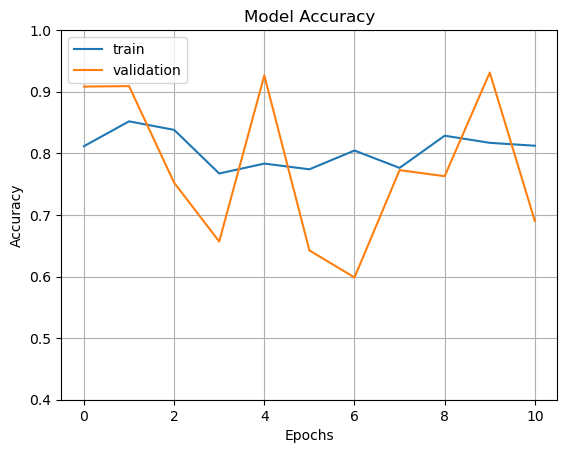

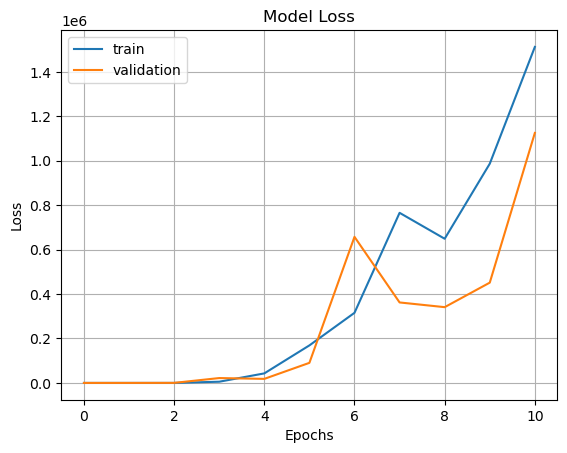

In [18]:
fig1 = plt.gcf()
plt.plot(history_effnet.history['accuracy'])
plt.plot(history_effnet.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


plt.plot(history_effnet.history['loss'])
plt.plot(history_effnet.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Predictions on Test data

In [19]:
prediction_effnet = saved_model.predict(test_ds) 
prediction_effnet=np.argmax(prediction_effnet,axis=1)

21/21 [==============================] - 30s 953ms/step


In [20]:
true_labels = []  

for image_batch, label_batch in test_ds:
    true_labels.append(label_batch)
    
correct_labels = tf.concat([item for item in true_labels], axis = 0)
correct_labels = correct_labels.numpy()

In [21]:
print(type(prediction_effnet))
print(type(correct_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### F1- Score, Precision & Recall

In [22]:
from sklearn.metrics import classification_report

print(classification_report(correct_labels, prediction_effnet))

              precision    recall  f1-score   support

           0       0.98      0.76      0.85       220
           1       0.80      0.97      0.87       220
           2       0.98      0.99      0.99       220

    accuracy                           0.91       660
   macro avg       0.92      0.91      0.91       660
weighted avg       0.92      0.91      0.91       660



### Confusion Matrix

<Axes: >

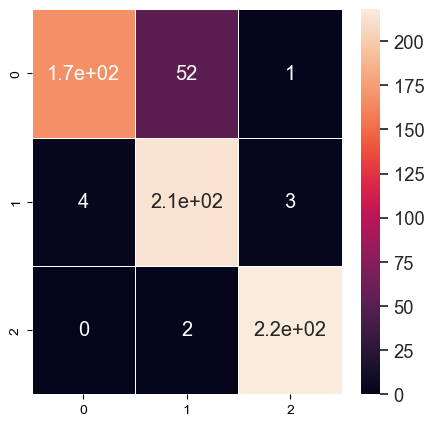

In [23]:
cm = confusion_matrix(correct_labels, prediction_effnet)

fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

### Add labels to an array

In [24]:
class_names = []

for directory in glob.glob("/Users/admin/Downloads/DSGP/Fruit Dataset_S/train/*"):
    label = os.path.basename(os.path.normpath(directory))
    class_names.append(label)

print(class_names)

['Unripe', 'Over Ripe', 'Ripe']


### Using the model for classification

In [28]:
from keras.models import load_model

load_imagePath = '/Users/admin/Downloads/DSGP/Ripe-Yellow-Mango-500x375.png'
saved_model = load_model('best_model_ripeness.h5')

<class 'numpy.ndarray'>
1/1 [==============================] - 11s 11s/step
[[5.7049710e-03 9.9429506e-01 6.7953211e-14]]
Classification:  Over Ripe
Value 0.99429506


/var/folders/dc/5z3pbmdn0y7432jf8nxdqh9r0000gn/T/ipykernel_63964/1842996424.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Classification: ",class_names[int(np.argmax(result,axis=1))])


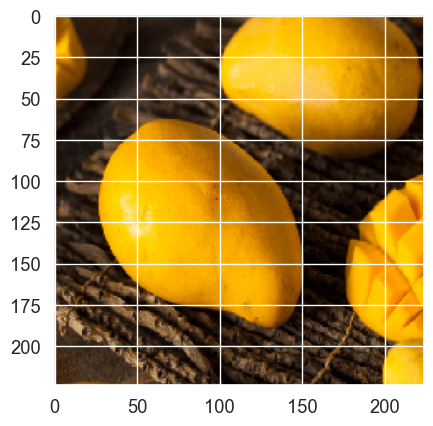

In [29]:
from keras.preprocessing import image

test_img = image.load_img(load_imagePath, target_size = IMAGE_SIZE) 
test_image = image.img_to_array(test_img)
test_image = np.expand_dims(test_image, axis = 0)
print(type(test_image))    
result = saved_model.predict(test_image)
print(result)
plt.imshow(test_img) 
print("Classification: ",class_names[int(np.argmax(result,axis=1))])
print("Value", np.amax(result))